# 코드 정리

In [2]:
!pip install category_encoders

# 기본 데이터 정리 및 처리
import numpy as np
import pandas as pd

# 시각화
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# 전처리
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler

# 경고 제거 (판다스가 에러 메세지를 자주 만들어 내기 때문에 이를 일단 무시하도록 설정합니다.)
import sys
import warnings

import warnings
warnings.filterwarnings('ignore')

# train, test 나누기
from sklearn.model_selection import train_test_split

import category_encoders as ce

from sklearn.compose import ColumnTransformer

In [3]:
df = pd.read_csv('../data/bank/bank-full.csv', sep =';')


# 종속변수 y를 수치형으로 바꿔주기. no를 0(정상)으로, yes를 1(이상)로 변환
df.loc[df['y'] == 'no', 'y'] = 0
df.loc[df['y'] == 'yes', 'y'] = 1
# object 타입을 int64 타입으로 바꿔주기
df['y'] = df['y'].astype('int64')

## unknown값 처리. 사실상 Null값과 같다고 판단. 전처리 진행.
df.drop('poutcome', axis=1, inplace = True) # poutcome 변수 삭제
unknowndr1 = df[df['job'].str.contains('unknown')].index
df.drop(unknowndr1, inplace=True)
unknowndr2 = df[df['education'].str.contains('unknown')].index
df.drop(unknowndr2, inplace=True)
unknowndr3 = df[df['contact'].str.contains('unknown')].index
df.drop(unknowndr3, inplace=True)

df.reset_index(drop=True, inplace = True) #인덱스 재 정렬

# y 변수 저장
df_labels = df['y']

#Binary Encoding
df_bi_cat = df[['month', 'job']]
df1 = ce.BinaryEncoder(cols = ['month']).fit_transform(df_bi_cat)
df2 = ce.BinaryEncoder(cols = ['job']).fit_transform(df1)

#One Hot Encoding
df_one_cat = df[['marital', 'education', 'default','housing',
       'loan', 'contact']] # month와 job을 제외한 범주형 변수 원핫인코딩

cat_pipeline = Pipeline([
    ('1hot_encoder', OneHotEncoder(sparse=False)),
    ])
df_cat_tr = cat_pipeline.fit_transform(df_one_cat)

#Robust Scaling
df_std_big_num = df[['balance', 'duration', 'pdays']] # 표준편차가 큰 수치형 변수
num_pipeline = Pipeline([
        ('rb_scaler', RobustScaler()),
    ])

df_num_tr = num_pipeline.fit_transform(df_std_big_num)

num_attribs = list(df_std_big_num) #키들(컬럼명)만 list로 반환
cat_attribs = list(df_one_cat)

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

full_df = pd.DataFrame(full_pipeline.fit_transform(df))

df_oth = df[['age', 'day', 'campaign', 'previous']] # 나머지 수치형 변수들

X = pd.concat([full_df,df2,df_oth], axis =1)
data = pd.concat([full_df,df2,df_oth, df_labels], axis =1)
data.columns

Index([         0,          1,          2,          3,          4,          5,
                6,          7,          8,          9,         10,         11,
               12,         13,         14,         15,         16,  'month_0',
        'month_1',  'month_2',  'month_3',    'job_0',    'job_1',    'job_2',
          'job_3',      'age',      'day', 'campaign', 'previous',        'y'],
      dtype='object')

In [4]:
# 정상/이상 구분
normal = data.loc[data['y'] == 0]
anomaly = data.loc[data['y'] == 1]

# 행 shuffle 후 위에서 4513개 --> test
normal_shuffled=normal.sample(frac=1, random_state=3).reset_index(drop=True) #shuffling
normal_shuffled_test = normal_shuffled[:4513]
normal_shuffled_train = normal_shuffled[4513:]

# train에 쓰이는 정상 데이터 X, Y 구분
X_train = normal_shuffled_train[normal_shuffled_train.columns.difference(['y'])]
Y_train = normal_shuffled_train["y"]

# test에 쓰이는 정상 데이터 X, Y 구분 (샘플링)
X_normal_shuffled_test = normal_shuffled_test[normal_shuffled_test.columns.difference(['y'])]
Y_normal_shuffled_test = normal_shuffled_test["y"]

# test에 쓰이는 이상 데이터 X, Y 구분
X_anomaly = anomaly[anomaly.columns.difference(['y'])]
y_anomaly = anomaly["y"]

X_test = pd.concat([X_normal_shuffled_test, X_anomaly])
Y_test = pd.concat([Y_normal_shuffled_test, y_anomaly])

X_train.columns

Index([         0,          1,          2,          3,          4,          5,
                6,          7,          8,          9,         10,         11,
               12,         13,         14,         15,         16,      'age',
       'campaign',      'day',    'job_0',    'job_1',    'job_2',    'job_3',
        'month_0',  'month_1',  'month_2',  'month_3', 'previous'],
      dtype='object')

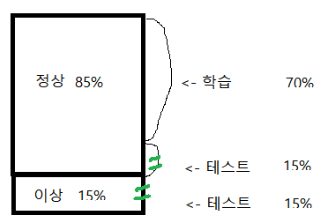

In [5]:
# 선형 상관성 존재하는 변수들 제거
X_train_lowcorr = X_train.drop([3, 5, 7, 9, 11, 13, 15, 'month_0', 'month_2'], axis=1)
X_test_lowcorr = X_test.drop([3, 5, 7, 9, 11, 13, 15, 'month_0', 'month_2'], axis=1)
X_test_lowcorr

,0,1,2,4,6,8,10,12,14,16,age,campaign,day,job_0,job_1,job_2,job_3,month_1,month_3,previous
0,4.426714,-0.064220,0.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,55,1,27,0,0,0,1,0,1,0
1,3.034095,0.178899,30.909091,1.0,0.0,0.0,0.0,1.0,1.0,0.0,33,1,11,0,1,0,0,0,0,4
2,-0.150439,-0.614679,0.000000,1.0,0.0,1.0,0.0,1.0,0.0,0.0,31,1,7,1,0,1,0,0,0,0
3,0.855536,-0.536697,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,60,11,28,1,0,1,0,0,0,0
4,-0.231986,-0.417431,0.000000,1.0,0.0,1.0,0.0,1.0,1.0,0.0,32,1,18,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30900,1.671002,0.545872,3.727273,1.0,0.0,0.0,0.0,0.0,0.0,0.0,73,1,17,1,0,0,1,1,0,8
30901,0.022496,0.940367,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,25,2,17,0,0,1,1,1,0,0
30902,0.247452,3.651376,0.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,51,3,17,0,0,1,1,1,0,0
30903,0.882953,1.261468,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,71,2,17,1,0,0,1,1,0,0


In [6]:
trainset = pd.concat([X_train_lowcorr,Y_train],axis = 1)
testset = pd.concat([X_test_lowcorr,Y_test],axis = 1)
dataset = pd.concat([trainset,testset],axis = 0)

Normal = dataset.loc[dataset['y'] == 0]
Anomaly = dataset.loc[dataset['y'] == 1]

* 참고로 

변수 0 은 balance의 로버스트 스케일링 한 것

변수 1 은 duration의 로버스트 스케일링 한 것

변수 2 는 pdays의 로버스트 스케일링 한 것

변수 3~16은 'marital', 'education', 'default','housing',
       'loan', 'contact' 원핫인코딩 한 것

In [7]:
dataset

,0,1,2,4,6,8,10,12,14,16,...,campaign,day,job_0,job_1,job_2,job_3,month_1,month_3,previous,y
4513,-0.313533,1.394495,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,25,0,1,0,0,0,0,0,0
4514,-0.215817,0.633028,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5,16,0,0,1,1,0,1,0,0
4515,-0.219332,0.206422,0.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,2,11,0,0,0,1,0,0,0,0
4516,0.075923,0.100917,0.000000,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,4,23,0,1,0,1,0,1,0,0
4517,-0.024605,0.417431,29.454545,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1,9,0,1,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30900,1.671002,0.545872,3.727273,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,17,1,0,0,1,1,0,8,1
30901,0.022496,0.940367,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,2,17,0,0,1,1,1,0,0,1
30902,0.247452,3.651376,0.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,3,17,0,0,1,1,1,0,0,1
30903,0.882953,1.261468,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,2,17,1,0,0,1,1,0,0,1


In [9]:
dataset.columns

Index([         0,          1,          2,          4,          6,          8,
               10,         12,         14,         16,      'age', 'campaign',
            'day',    'job_0',    'job_1',    'job_2',    'job_3',  'month_1',
        'month_3', 'previous',        'y'],
      dtype='object')

In [12]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
cols = [         0,          1,          2,          4,          6,          8,
               10,         12,         14,         16,      'age', 'campaign',
            'day',    'job_0',    'job_1',    'job_2',    'job_3',  'month_1',
        'month_3', 'previous']
dataset[cols] = min_max_scaler.fit_transform(dataset[cols])

dataset.head()

,0,1,2,4,6,8,10,12,14,16,...,campaign,day,job_0,job_1,job_2,job_3,month_1,month_3,previous,y
4513,0.073048,0.098617,0.00000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.800000,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0
4514,0.074310,0.064864,0.00000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.081633,0.500000,0.0,0.0,1.0,1.0,0.0,1.0,0.000000,0
4515,0.074265,0.045954,0.00000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.020408,0.333333,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0
4516,0.078078,0.041277,0.00000,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.061224,0.733333,0.0,1.0,0.0,1.0,0.0,1.0,0.000000,0
4517,0.076780,0.055307,0.37156,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.000000,0.266667,0.0,1.0,1.0,0.0,0.0,1.0,0.003636,0


In [6]:
#정상 데이터의 변수별 분포 확인

# for col in dataset.columns:
#     sns.distplot(Normal.loc[Normal[col].notnull(), col])
#     plt.title(col)
#     plt.show()

In [7]:
#이상 데이터의 변수별 분포 확인

# for col in dataset.columns:
#     sns.distplot(Anomaly.loc[Anomaly[col].notnull(), col])
#     plt.title(col)
#     plt.show()